# Tutorial

## Relevant imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyforfluids as pff

## Definition of the model to be used

In [2]:
model = pff.models.GERG2008()

## Fluid's initial state

In [3]:
temperature = 250  # Degrees Kelvin
density = 1  # mol/L
pressure = 101325  # Pa
composition = {'methane': 0.9, 'ethane': 0.05, 'propane': 0.05}  # Molar fractions

### Definition of the fluid
The properties will be calculated at the moment of the object definition.

In [4]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    density=density
)

#### Pressure as an init variable
Pressure can be used as an initial variable, in this case the method `fluid.density_iterator` will be called internally to find the root of density at the given pressure, since all models use density as an independent variable instead of temperature. 

This can lead to trouble since multiple roots can be obtained in the equilibrium region!

In [5]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    pressure=pressure
)

### Accessing properties

Properties are stored in the Fluid attribute `Fluid.properties` as a dictionary, they can either be accessed that way or by calling them directly from the fluid.

All the properties are expressed in **International System** units, except for density that's expressed in **[mol/L]**

In [6]:
fluid.properties

{'density_r': 9.442772800175154,
 'temperature_r': 207.1068112975803,
 'delta': 0.005162295708090389,
 'tau': 0.8284272451903212,
 'ao': array([[-3.47583079e+01,  0.00000000e+00,  0.00000000e+00],
        [ 1.93712266e+02, -4.99964400e+01,  0.00000000e+00],
        [-3.75244420e+04, -5.41251465e+00,  0.00000000e+00]]),
 'ar': array([[-0.0041676 ,  0.        ,  0.        ],
        [-0.80651578, -0.0108937 ,  0.        ],
        [ 0.31041621, -0.00769256, -2.10957546]]),
 'z': 0.9958365270355344,
 'cv': 30.928532328981273,
 'cp': 39.39441402789975,
 'w': 380.3778978355614,
 'isothermal_thermal_coefficent': -0.2725846588975132,
 'dp_dt': 0.4072695321069243,
 'dp_drho': 2061.3266554120955,
 'dp_dv': -4.898145216338861,
 'p': 100903.24995863381,
 's': -55.41564180556873,
 'u': -86111.8177689482,
 'h': -84041.85403879466,
 'g': -70187.94358740246,
 'jt': 0.00035980611360190225,
 'k': 1.2633809737968698,
 'b': -0.08557993798318263,
 'c': 0.003479888600305259}

In [7]:
fluid['cv']

30.928532328981273

### State changes

A fluid thermodynamic variable can be changed by using the methods:

- `Fluid.set_temperature`
- `Fluid.set_composition`
- `Fluid.set_density`
- `Fluid.set_pressure`

When a property is changed, the properties are not re-calculated, so it's a **must** to call the method `Fluid.calculate_properties`. This is intended to avoid useless calculations if two or more variables are to be changed. In the case of a pressure change `Fluid.density_iterator` will be called!

In [8]:
fluid.set_temperature(280)
fluid.set_density(2)

fluid.calculate_properties()

In [9]:
fluid['cv']

34.71399971808808

## Calculating isotherms

Isotherms at the fluid temperature can be calculated along a density range with the method `Fluid.isotherm`. This will return a dictionary equivalent to the `Fluid.properties` one, but each value will be a list instead of a single value.

In [10]:
density_range = np.linspace(0.001, 20, 100)
isotherm = fluid.isotherm(density_range)

In [11]:
isotherm['cv'][:5]

[33.34361845195672,
 33.48240604268746,
 33.622421620895594,
 33.76309070522664,
 33.903893177656855]

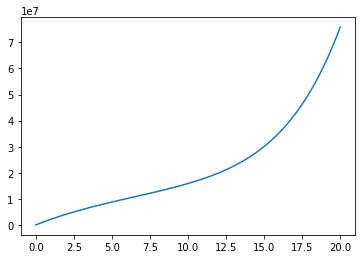

In [12]:
plt.plot(density_range, isotherm['p'])
plt.show()